In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

In [2]:
from utilities.imports import *

In [3]:
#typical example setup
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'
x_train, y_train, x_valid, y_valid = get_data(MNIST_URL)
x_train, x_valid = normalize_to(x_train, x_valid)

number_hidden = 50
batch_size = 512
num_categories = y_train.max().item()+1

loss_function = F.cross_entropy

#data 
training_ds = Dataset(x_train, y_train)
validation_ds = Dataset(x_valid, y_valid)
train_dl = DataLoader(training_ds, batch_size, shuffle = True) #random sampler
valid_dl = DataLoader(validation_ds, batch_size*2, shuffle = False) #sequential sampler
number_features = [8,16,32,32]

#callbacks
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(IndependentVarBatchTransformCallback,mnist_view)]

# Paper: 
### Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
<https://arxiv.org/abs/1502.03167>

#### Custom BatchNorm

In [4]:
class Batch_Normalization(nn.Module):
    def __init__(self, num_feat, momentum=0.1, epsilon=1e-5):
        super().__init__()
        self.momentum = momentum
        self.epsilon = epsilon
        self.multipliers = nn.Parameter(torch.ones(num_feat, 1, 1))
        self.adds = nn.Parameter(torch.zeros(num_feat, 1, 1))
        self.register_buffer('variances', torch.ones(1,num_feat, 1, 1))
        self.register_buffer('means', torch.zeros(1,num_feat, 1, 1))
                             
    def update_stats(self, inpt):
        n_mean = inpt.mean((0,2,3), keepdim=True)
        n_var = inpt.var((0,2,3), keepdim=True)
        self.means._lerp(n_mean, self.momentum)
        self.variances.lerp_(n_var, self.momentum)
        return n_mean, n_var
    
    def forward(self, inpt):
        if self.training:
            with torch.no_grad():
                mean, var = self.update_stats(inpt)
        else:
            mean, var = self.means, self.variances
        inpt = (inpt - mean) / (var+self.epsilon).sqrt()
        return x*self.multipliers + self.adds         

In [5]:
model = get_cnn_model(num_categories, number_features, conv_layer)
init_cnn(model)
opt = optim.SGD(model.parameters(), lr=0.9)
runner = Runner(cb_funcs=cbfs)

train: [0.350956640625, tensor(0.9016, device='cuda:0')]
valid: [0.10992724609375, tensor(0.9671, device='cuda:0')]


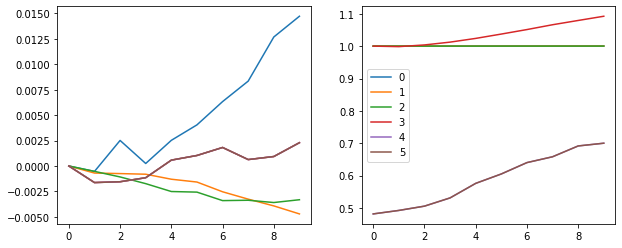

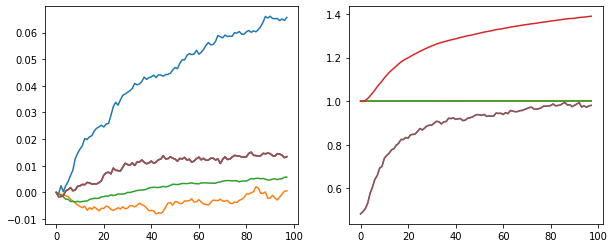

In [6]:
with Hooks(model, append_mean_std) as hooks:
    runner.fit(1, model, opt, loss_function, train_dl, valid_dl)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

### demonstrating the power of BatchNorm
![palpatine](https://media.giphy.com/media/hokMyu1PAKfJK/giphy.gif)

In [7]:
sched = combine_schedules([0.3, 0.7], [linear_scheduler(0.6, 2.), linear_scheduler(2., 0.1)]) 

In [8]:
model = get_cnn_model(num_categories, number_features, conv_layer)
init_cnn(model)
opt = optim.SGD(model.parameters(), lr=0.9)
cbfs += [partial(ParamScheduler, 'lr', sched)]
runner = Runner(cb_funcs=cbfs)

In [9]:
runner.fit(8, model, opt , loss_function, train_dl, valid_dl)

train: [0.4207510546875, tensor(0.8831, device='cuda:0')]
valid: [0.243477490234375, tensor(0.9244, device='cuda:0')]
train: [0.098016123046875, tensor(0.9698, device='cuda:0')]
valid: [0.1275370361328125, tensor(0.9605, device='cuda:0')]
train: [0.06614048828125, tensor(0.9790, device='cuda:0')]
valid: [0.06896677856445313, tensor(0.9790, device='cuda:0')]
train: [0.04324146484375, tensor(0.9866, device='cuda:0')]
valid: [0.06803539428710938, tensor(0.9793, device='cuda:0')]
train: [0.03116916015625, tensor(0.9904, device='cuda:0')]
valid: [0.05618128662109375, tensor(0.9839, device='cuda:0')]
train: [0.021960078125, tensor(0.9939, device='cuda:0')]
valid: [0.0474327880859375, tensor(0.9866, device='cuda:0')]
train: [0.01527841552734375, tensor(0.9962, device='cuda:0')]
valid: [0.04550476684570313, tensor(0.9865, device='cuda:0')]
train: [0.011830645751953126, tensor(0.9974, device='cuda:0')]
valid: [0.04492804260253906, tensor(0.9872, device='cuda:0')]


### Downsides of Batch Normalization
- cannot be applied to online learning
- cannot be applied to large distributed models, where the minibatches are small
    - the variance of a minibatch of size 1 is infinity

In [10]:
train_dl = DataLoader(training_ds, 2, shuffle = True) #random sampler
valid_dl = DataLoader(validation_ds, 2, shuffle = False) #sequential sampler
model = get_cnn_model(num_categories, number_features, conv_layer)
init_cnn(model)
opt = optim.SGD(model.parameters(), lr=0.4)
cbfs += [partial(ParamScheduler, 'lr', sched)]
runner = Runner(cb_funcs=cbfs)

In [11]:
runner.fit(1, model, opt , loss_function, train_dl, valid_dl)

train: [nan, tensor(0.1126, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
